In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
import zipfile
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Specify paths
drive_path = '/content/drive/MyDrive/Colab Notebooks'  # Adjust if your file is in a different folder
zip_file_path = os.path.join(drive_path, 'Dataset.zip')  # Change to your zip file name
extract_path = '/content/dataset'  # Where to extract files

# 3. Create extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# 4. Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print(f"Extracted files to: {extract_path}")

# 5. Verify the extracted folders
dataset_path = os.path.join(extract_path, 'extract')  # Change to your extracted folder name
train_dir = os.path.join(dataset_path, '/content/dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/train')
val_dir = os.path.join(dataset_path, '/content/dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/val')
test_dir = os.path.join(dataset_path, '/content/dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test')

print("\nVerifying directories:")
print("Train exists:", os.path.exists(train_dir))
print("Validation exists:", os.path.exists(val_dir))
print("Test exists:", os.path.exists(test_dir))

# 6. Sample directory listing (optional)
if os.path.exists(train_dir):
    print("\nSample train directory contents:")
    print(os.listdir(train_dir)[:5])  # Show first 5 items

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted files to: /content/dataset

Verifying directories:
Train exists: True
Validation exists: True
Test exists: True

Sample train directory contents:
['fish sea_food hourse_mackerel', 'fish sea_food shrimp', 'fish sea_food red_mullet', 'fish sea_food gilt_head_bream', 'fish sea_food black_sea_sprat']


In [ ]:

## Data Preprocessing and Augmentation

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]

    # Data augmentation parameters
    rotation_range=20,  # Random rotation between -20 and +20 degrees
    width_shift_range=0.2,  # Random horizontal shift by ±20% of width
    height_shift_range=0.2,  # Random vertical shift by ±20% of height
    zoom_range=0.2,  # Random zoom between 80% and 120%
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=False,  # No vertical flipping (can enable if appropriate)
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Validation and test generators (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Set image size and batch size
img_width, img_height = 224, 224  # Adjust as needed
batch_size = 32  # Adjust as needed

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # or 'binary' if you have two classes
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [ ]:
# Get class names and number of classes
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']
Number of classes: 11


In [ ]:

# Build a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,771 (18.42 MB)

 Trainable params: 4,829,771 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Train the model
epochs = 15
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.2656 - loss: 2.0642 - precision: 0.6775 - recall: 0.0872 - val_accuracy: 0.6002 - val_loss: 1.1325 - val_precision: 0.8307 - val_recall: 0.3925
Epoch 2/15
  1/194 ━━━━━━━━━━━━━━━━━━━━ 4:16 1s/step - accuracy: 0.6250 - loss: 0.9567 - precision: 0.7647 - recall: 0.4062

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


194/194 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.6250 - loss: 0.9567 - precision: 0.7647 - recall: 0.4062 - val_accuracy: 0.6287 - val_loss: 1.1154 - val_precision: 0.8263 - val_recall: 0.3980
Epoch 3/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.5752 - loss: 1.1489 - precision: 0.7522 - recall: 0.3900 - val_accuracy: 0.5634 - val_loss: 1.4811 - val_precision: 0.6343 - val_recall: 0.4991
Epoch 4/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.6250 - loss: 0.9332 - precision: 0.7308 - recall: 0.5938 - val_accuracy: 0.6259 - val_loss: 1.1682 - val_precision: 0.7023 - val_recall: 0.5616
Epoch 5/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.7084 - loss: 0.8293 - precision: 0.8198 - recall: 0.5924 - val_accuracy: 0.6636 - val_loss: 1.0366 - val_precision: 0.7158 - val_recall: 0.6296
Epoch 6/15
194/194 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.6562 - loss: 0.8509 - precision: 0.8000 - recall: 0.6250 - val_accuracy: 0.7693 - val_loss: 0.646

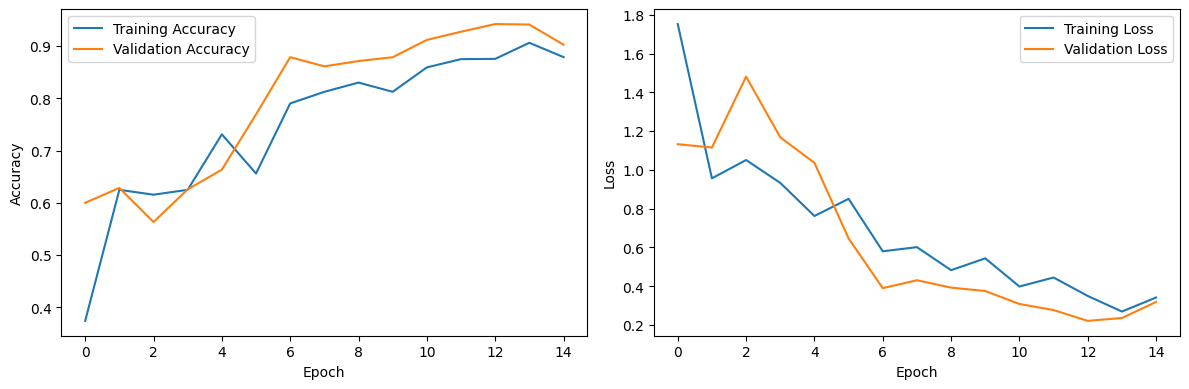

In [ ]:

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [ ]:
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 425ms/step - accuracy: 0.9228 - loss: 0.2336 - precision: 0.9330 - recall: 0.9128

Test accuracy: 0.8927
Test precision: 0.9082
Test recall: 0.8751


In [ ]:
# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 508ms/step


In [ ]:
# Get true classes
true_classes = test_generator.classes

In [ ]:
# Classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
print('\nConfusion Matrix:')
print(conf_mat)


Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.97      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.86      1.00      0.93       298
   fish sea_food gilt_head_bream       0.95      0.67      0.79       305
   fish sea_food hourse_mackerel       0.84      0.89      0.87       286
        fish sea_food red_mullet       0.93      1.00      0.96       291
     fish sea_food red_sea_bream       0.98      0.87      0.92       273
          fish sea_food sea_bass       0.76      0.84      0.80       327
            fish sea_food shrimp       0.78      1.00      0.88       289
fish sea_food striped_red_mullet       0.90      0.67      0.77       293
             fish sea_food trout       0.98      0.98      0.98       292

                        accuracy                           0.89      3187
            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Setup and Data Preparation
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import (VGG16, ResNet50, MobileNet,
                                          InceptionV3, EfficientNetB0)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dataset_path = os.path.join(extract_path, 'extract')

train_dir = os.path.join(dataset_path, '/content/dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/train')
val_dir = os.path.join(dataset_path, '/content/dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/val')
test_dir = os.path.join(dataset_path, '/content/dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test')


# Data generators setup
img_size = (224, 224)
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

# Results storage
model_comparison = []

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.


In [ ]:
#VGG16 Evaluation
def evaluate_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

vgg_model, vgg_history = evaluate_vgg16()
model_comparison.append({
    'Model': 'VGG16',
    'Val Accuracy': max(vgg_history.history['val_accuracy']),
    'Val Precision': max(vgg_history.history['val_precision']),
    'Val Recall': max(vgg_history.history['val_recall']),
    'Parameters': f"{vgg_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Medium-sized datasets'
})

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 127s 564ms/step - accuracy: 0.2235 - loss: 2.2319 - precision: 0.7020 - recall: 0.0123 - val_accuracy: 0.6282 - val_loss: 1.6998 - val_precision: 0.9350 - val_recall: 0.1053
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 500ms/step - accuracy: 0.5541 - loss: 1.6420 - precision: 0.9646 - recall: 0.1144 - val_accuracy: 0.6932 - val_loss: 1.3944 - val_precision: 0.9396 - val_recall: 0.1282
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 142s 501ms/step - accuracy: 0.6702 - loss: 1.3690 - precision: 0.9607 - recall: 0.1491 - val_accuracy: 0.7647 - val_loss: 1.1936 - val_precision: 0.9485 - val_recall: 0.1685
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 493ms/step - accuracy: 0.7265 - loss: 1.2038 - precision: 0.9667 - recall: 0.1942 - val_accuracy: 0.7830 - val_loss: 1.0486 - val_precision: 0.9652 - val_recall: 0.2793
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 507ms/step - accuracy: 0.7477 - loss: 1.0805 - prec

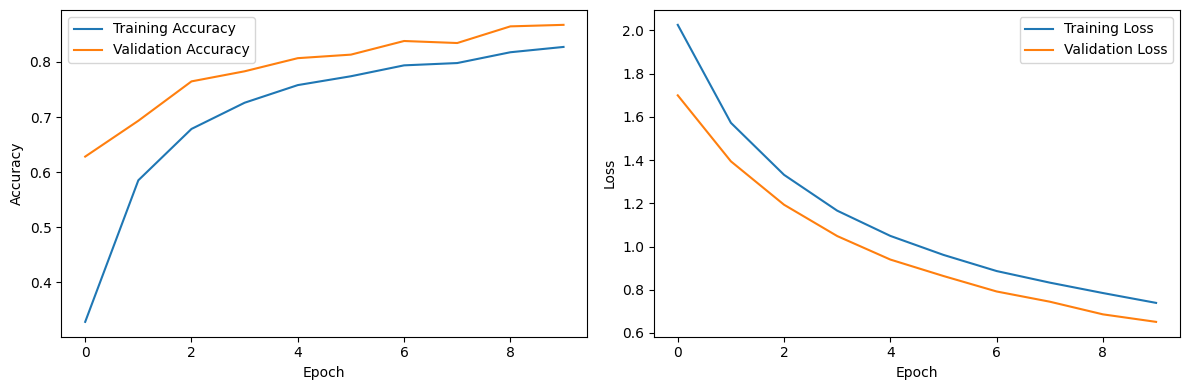

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step - accuracy: 0.8947 - loss: 0.5037 - precision: 0.9752 - recall: 0.7215

Test accuracy: 0.8648
Test precision: 0.9728
Test recall: 0.6501
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step


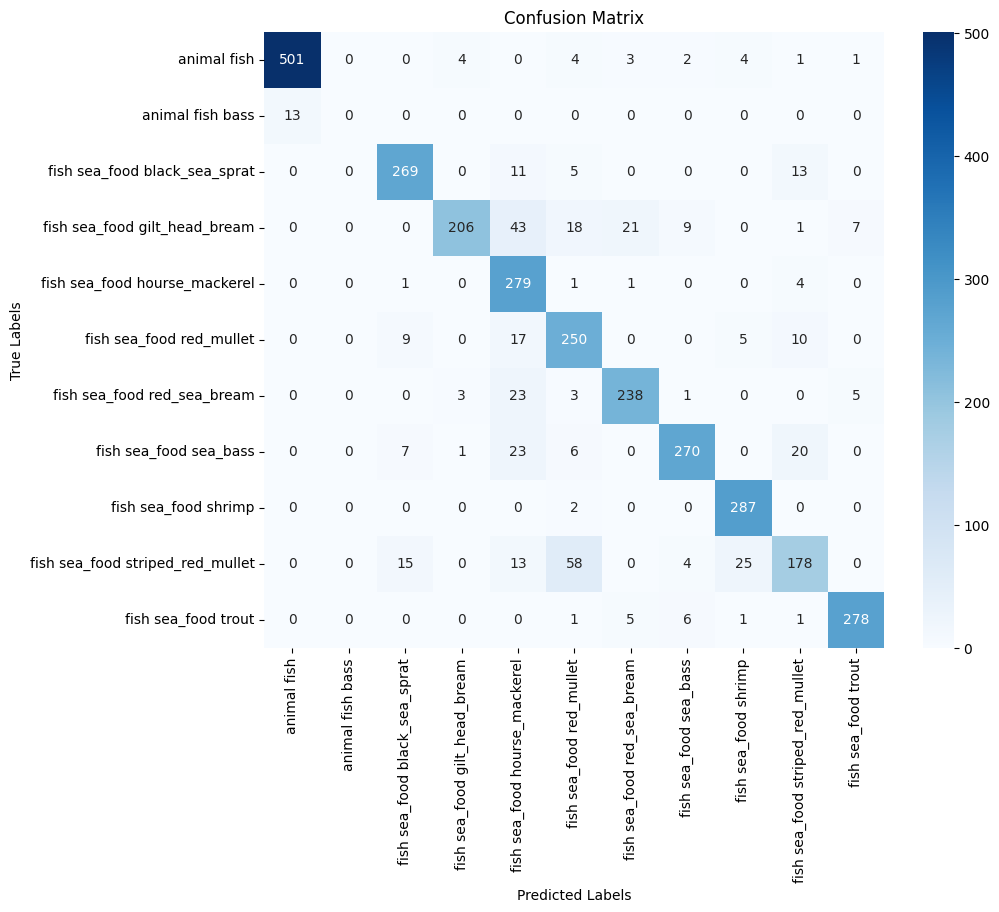

In [ ]:
#training history and confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(vgg_history)


# Evaluate on test set (assuming you have a test_generator)
test_generator.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = vgg_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = vgg_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# ResNet50 Evaluation
def evaluate_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

resnet_model, resnet_history = evaluate_resnet50()
model_comparison.append({
    'Model': 'ResNet50',
    'Val Accuracy': max(resnet_history.history['val_accuracy']),
    'Val Precision': max(resnet_history.history['val_precision']),
    'Val Recall': max(resnet_history.history['val_recall']),
    'Parameters': f"{resnet_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'General purpose'
})

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 116s 517ms/step - accuracy: 0.1370 - loss: 2.3954 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1813 - val_loss: 2.2354 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 462ms/step - accuracy: 0.1981 - loss: 2.2408 - precision: 0.1828 - recall: 6.1077e-05 - val_accuracy: 0.2097 - val_loss: 2.1931 - val_precision: 1.0000 - val_recall: 9.1575e-04
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 89s 456ms/step - accuracy: 0.1943 - loss: 2.1982 - precision: 0.7112 - recall: 0.0020 - val_accuracy: 0.2463 - val_loss: 2.1435 - val_precision: 1.0000 - val_recall: 0.0055
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 88s 450ms/step - accuracy: 0.2085 - loss: 2.1563 - precision: 0.8374 - recall: 0.0055 - val_accuracy: 0.2253 - val_loss: 2.0931 - val_precision: 1.0000 - val_recall: 0.0165
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 92s 470ms/step - accuracy: 0.2230 - loss: 2.1405 - precision: 0.8968 - recall: 0.00

In [ ]:
# Cell 4: MobileNet Evaluation
def evaluate_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

mobilenet_model, mobilenet_history = evaluate_mobilenet()
model_comparison.append({
    'Model': 'MobileNet',
    'Val Accuracy': max(mobilenet_history.history['val_accuracy']),
    'Val Precision': max(mobilenet_history.history['val_precision']),
    'Val Recall': max(mobilenet_history.history['val_recall']),
    'Parameters': f"{mobilenet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Mobile/Edge devices'
})

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 462ms/step - accuracy: 0.5557 - loss: 1.4494 - precision: 0.7312 - recall: 0.3852 - val_accuracy: 0.9606 - val_loss: 0.2079 - val_precision: 0.9844 - val_recall: 0.9249
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 85s 437ms/step - accuracy: 0.9412 - loss: 0.2364 - precision: 0.9643 - recall: 0.9067 - val_accuracy: 0.9899 - val_loss: 0.0937 - val_precision: 0.9907 - val_recall: 0.9780
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 420ms/step - accuracy: 0.9668 - loss: 0.1413 - precision: 0.9749 - recall: 0.9514 - val_accuracy: 0.9927 - val_loss: 0.0667 - val_precision: 0.9945 - val_recall: 0.9908
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 417ms/step - accuracy: 0.9714 - loss: 0.1087 - precision: 0.9790 - recall: 0.9664 - val_accuracy: 0.9954 - val_loss: 0.0465 - val_precision: 0.9954 - val_recall: 0.9936
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 420ms/step - accuracy: 0.9781 - loss: 0.0788 - precis

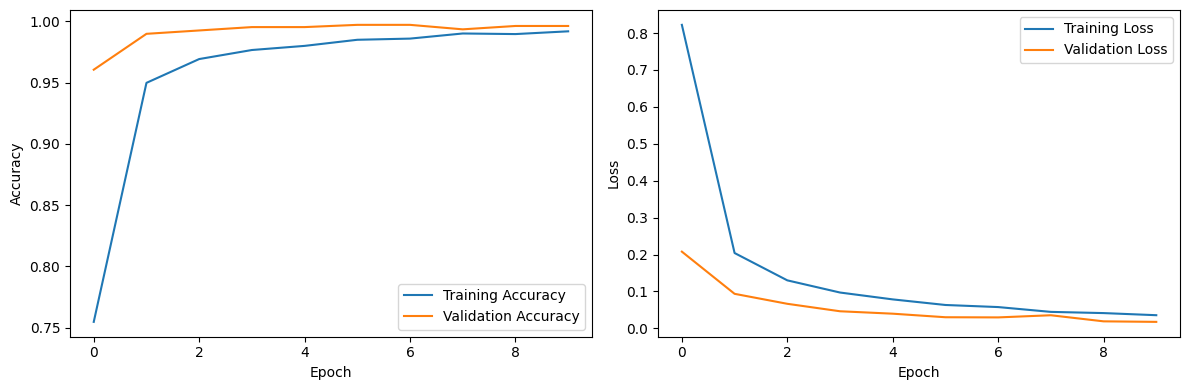

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9970 - loss: 0.0219 - precision: 0.9970 - recall: 0.9970

MobileNet Test accuracy: 0.9975
MobileNet Test precision: 0.9978
MobileNet Test recall: 0.9975
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step


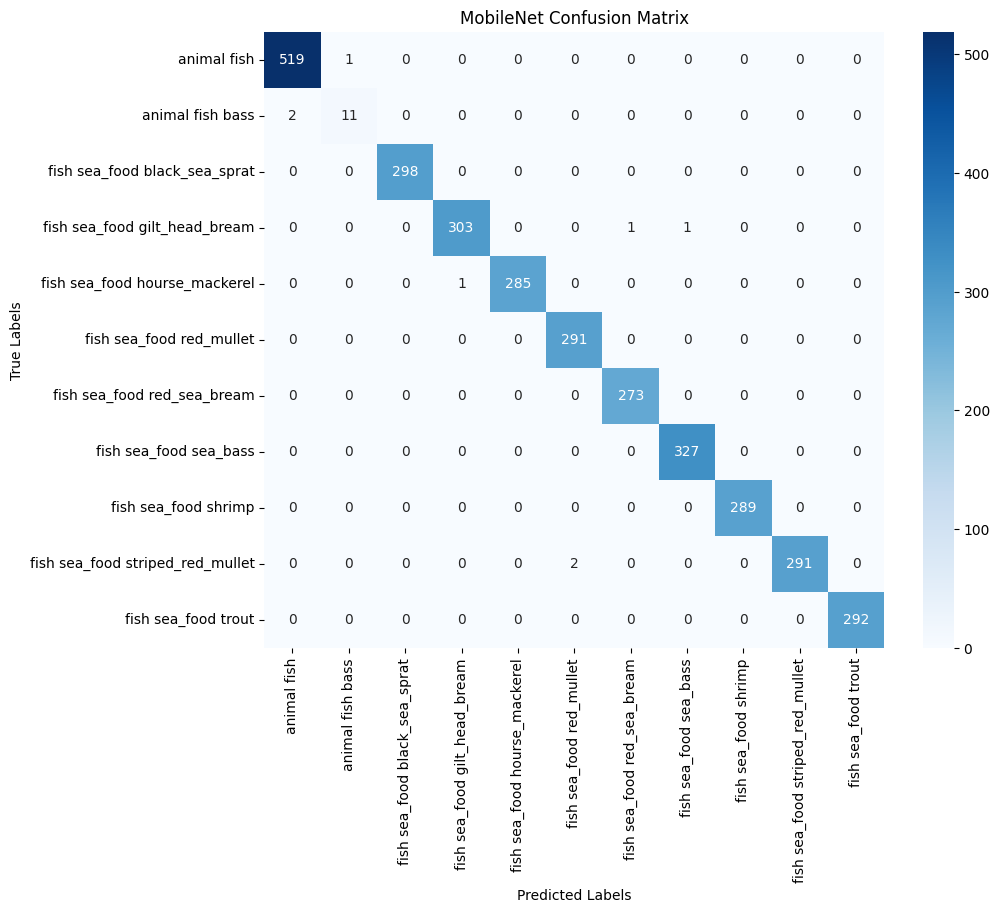

In [ ]:
# Plot training history for MobileNet
plot_history(mobilenet_history)

# Evaluate on test set for MobileNet
test_generator.reset()  # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = mobilenet_model.evaluate(test_generator)
print(f'\nMobileNet Test accuracy: {test_acc:.4f}')
print(f'MobileNet Test precision: {test_precision:.4f}')
print(f'MobileNet Test recall: {test_recall:.4f}')

# Generate predictions for MobileNet
predictions = mobilenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes for MobileNet
true_classes = test_generator.classes

# Confusion Matrix for MobileNet
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix for MobileNet using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MobileNet Confusion Matrix')
plt.show()


In [ ]:
# InceptionV3 Evaluation
def evaluate_inception():
    # Special generator for Inception's 299x299 input
    inception_train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=(299, 299), batch_size=batch_size)
    inception_val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=(299, 299), batch_size=batch_size)

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(299, 299, 3))
    x = tf.keras.applications.inception_v3.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        inception_train_gen,
        validation_data=inception_val_gen,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

inception_model, inception_history = evaluate_inception()
model_comparison.append({
    'Model': 'InceptionV3',
    'Val Accuracy': max(inception_history.history['val_accuracy']),
    'Val Precision': max(inception_history.history['val_precision']),
    'Val Recall': max(inception_history.history['val_recall']),
    'Parameters': f"{inception_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Multi-scale features'
})

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 198s 900ms/step - accuracy: 0.1810 - loss: 2.2938 - precision: 0.5106 - recall: 3.9042e-04 - val_accuracy: 0.2857 - val_loss: 2.0915 - val_precision: 1.0000 - val_recall: 0.0055
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 149s 764ms/step - accuracy: 0.2441 - loss: 2.1175 - precision: 0.8944 - recall: 0.0161 - val_accuracy: 0.3141 - val_loss: 1.9706 - val_precision: 0.9787 - val_recall: 0.0421
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 151s 775ms/step - accuracy: 0.2827 - loss: 2.0280 - precision: 0.9717 - recall: 0.0367 - val_accuracy: 0.3535 - val_loss: 1.9107 - val_precision: 0.9730 - val_recall: 0.0659
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 155s 795ms/step - accuracy: 0.2921 - loss: 1.9796 - precision: 0.9505 - recall: 0.0598 - val_accuracy: 0.3810 - val_loss: 1.8473 - val_precision: 0.9747 - val_recall: 0.0705
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 153s 783ms/step - accuracy: 0.3301 - loss: 1.9191 - precision: 0.9359 - recall: 0.0667 - val_accurac

In [ ]:
#EfficientNetB0 Evaluation
def evaluate_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

efficientnet_model, efficientnet_history = evaluate_efficientnet()
model_comparison.append({
    'Model': 'EfficientNetB0',
    'Val Accuracy': max(efficientnet_history.history['val_accuracy']),
    'Val Precision': max(efficientnet_history.history['val_precision']),
    'Val Recall': max(efficientnet_history.history['val_recall']),
    'Parameters': f"{efficientnet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Best accuracy/efficiency tradeoff'
})

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 521ms/step - accuracy: 0.1576 - loss: 2.3319 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1712 - val_loss: 2.3356 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 112s 421ms/step - accuracy: 0.1653 - loss: 2.3250 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0824 - val_loss: 2.3693 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 424ms/step - accuracy: 0.1522 - loss: 2.3328 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1712 - val_loss: 2.3291 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 83s 428ms/step - accuracy: 0.1701 - loss: 2.3158 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1712 - val_loss: 2.3248 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 423ms/step - accuracy: 0.1609 - loss: 

In [ ]:
#Results Comparison
comparison_df = pd.DataFrame(model_comparison)
comparison_df = comparison_df.sort_values('Val Accuracy', ascending=False)
comparison_df.style.background_gradient(cmap='Blues', subset=['Val Accuracy', 'Val Precision', 'Val Recall'])

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
1,MobileNet,0.997253,0.997250,0.996337,"3,240,139",Fast,Mobile/Edge devices
5,VGG16,0.867216,0.968037,0.635531,"14,720,331",Medium,Medium-sized datasets
2,InceptionV3,0.447802,1.000000,0.107143,"21,825,323",Medium,Multi-scale features
0,ResNet50,0.309524,1.000000,0.043956,"23,610,251",Medium,General purpose
3,EfficientNetB0,0.171245,0.000000,0.000000,"4,063,662",Fast,Best accuracy/efficiency tradeoff
4,EfficientNetB0,0.171245,0.000000,0.000000,"4,063,662",Fast,Best accuracy/efficiency tradeoff


In [ ]:
# Save the DataFrame to a CSV file
comparison_df.to_csv('/content/drive/MyDrive/model_comparison.csv', index=False)


In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/model_comparison.csv')
df


,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
0,MobileNet,0.997253,0.997250,0.996337,"3,240,139",Fast,Mobile/Edge devices
1,VGG16,0.867216,0.968037,0.635531,"14,720,331",Medium,Medium-sized datasets
2,InceptionV3,0.447802,1.000000,0.107143,"21,825,323",Medium,Multi-scale features
3,ResNet50,0.309524,1.000000,0.043956,"23,610,251",Medium,General purpose
4,EfficientNetB0,0.171245,0.000000,0.000000,"4,063,662",Fast,Best accuracy/efficiency tradeoff
5,EfficientNetB0,0.171245,0.000000,0.000000,"4,063,662",Fast,Best accuracy/efficiency tradeoff


The best performing model is:
Model                       MobileNet
Val Accuracy                 0.997253
Val Precision                 0.99725
Val Recall                   0.996337
Parameters                  3,240,139
Inference Time                   Fast
Best For          Mobile/Edge devices
Name: 0, dtype: object


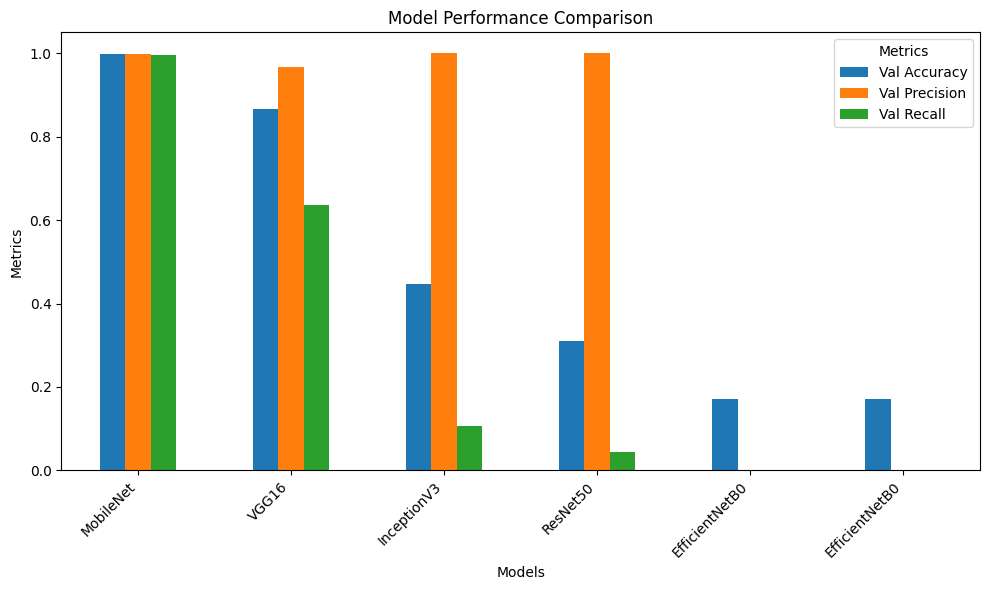

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/model_comparison.csv')


# Find the best model based on validation accuracy
best_model = df.loc[df['Val Accuracy'].idxmax()]

print(f"The best performing model is:\n{best_model}")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
df.plot(x='Model', y=['Val Accuracy', 'Val Precision', 'Val Recall'], kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metrics')
plt.xlabel('Models')


plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


In [ ]:
# save the model

mobilenet_model.save('/content/drive/MyDrive/mobilenet_model.h5')


In [8]:
# Install required packages
!pip install streamlit numpy pillow tensorflow pyngrok

In [14]:
#Create the Streamlit app for custom fish classification
%%writefile custom_fish_classifier.py
import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import os


FISH_CLASSES=['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']


# Load stom trained model
@st.cache_resource
def load_custom_model():
    model_path = '/content/drive/MyDrive/mobilenet_model.h5'
    if not os.path.exists(model_path):
        st.error(f"Model file not found at {model_path}")
        return None
    return load_model(model_path)

model = load_custom_model()

# Streamlit app
st.title("🎣 Custom Fish Species Classifier")
st.write(f"Upload a fish image to classify")

# File uploader
uploaded_file = st.file_uploader("Choose a fish image...",
                                type=["jpg", "jpeg", "png"])

if uploaded_file is not None and model is not None:
    # Display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess the image
    image = image.resize((224, 224))  # Match your model's expected input
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Normalize (if your model expects this)
    image_array = np.expand_dims(image_array, axis=0)

    # Make prediction
    with st.spinner('Identifying fish species...'):
        predictions = model.predict(image_array)
        predicted_class = FISH_CLASSES[np.argmax(predictions)]
        confidence = np.max(predictions)

    # Display results
    st.subheader("Prediction Results:")
    st.success(f"Species: {predicted_class}")
    st.info(f"Confidence: {confidence*100:.2f}%")

    # Show all class probabilities
    st.subheader("All Class Probabilities:")
    for i, (cls, prob) in enumerate(zip(FISH_CLASSES, predictions[0])):
        st.write(f"{cls}: {prob*100:.2f}%")
        st.progress(float(prob))



Overwriting custom_fish_classifier.py


In [12]:
!pip install pyngrok --upgrade
from pyngrok import ngrok
# Kill any existing Streamlit servers
!pkill -f streamlit

# Start Streamlit in background
get_ipython().system_raw('streamlit run custom_fish_classifier.py --server.port 8501 &')


tunnel=ngrok.connect(8501,"http",bind_tls=True)
public_url=tunnel.public_url
print("Your Streamlit app is available at:",public_url)


Your Streamlit app is available at: https://caee-34-34-100-136.ngrok-free.app
